# Cooperative optimization for data science

## Load the data

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import minimize
import cvxpy as cp
import math


In [54]:
with open("first_database.pkl", "rb") as f:
    x,y = pickle.load(f)

Text(0.5, 1.0, 'Data visualization')

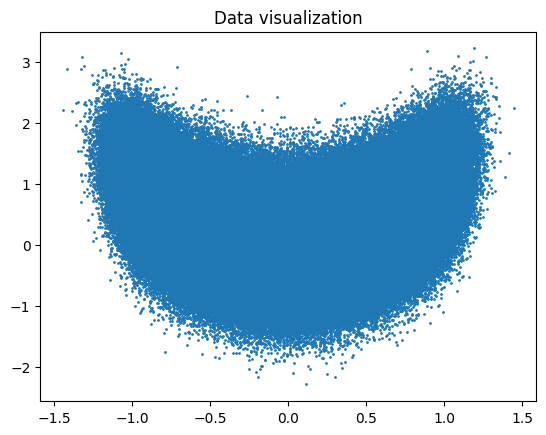

In [55]:
plt.scatter(x, y, s=1)
plt.title("Data visualization")

## Define the parameters

In [56]:
n = 100 # x_selected
m = 10
a = 5
sigma = 0.5
nu = 1

In [57]:
sel = [i for i in range(n)]
ind = np.random.choice(sel, m, replace=False)
x_selected = [x[i] for i in ind]
y_selected = [y[i] for i in ind]

Text(0, 0.5, 'y')

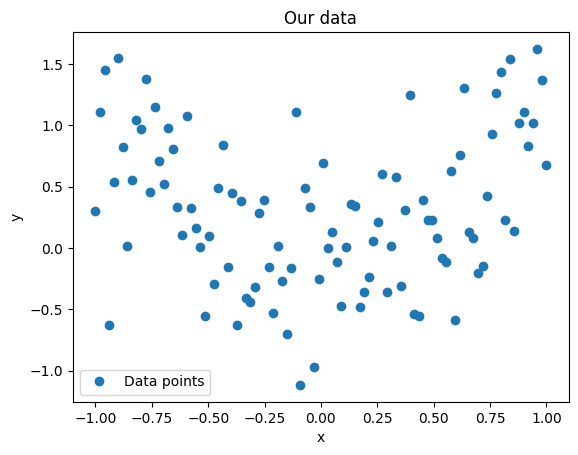

In [58]:
# Plot the selected points

plt.plot(x[:n],y[:n],'o', label = "Data points")
#plt.plot(x_selected,y_selected,'o',label="Selected points")
plt.title("Our data")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

<h2> Utils

In [59]:
def kernel(x, y):
    K = np.exp(-np.linalg.norm(x - y)**2)
    return K

In [60]:
def matrix_K(x, y):
    p = len(x)
    q = len(y)
    K = np.zeros((p,q))
    for i in range(p):
        for j in range(q):
            K[i][j] = kernel(x[i],y[j])
    return K

In [77]:
def plot_f(nt, alpha_method, title, method):
    x_prime = np.linspace(-1, 1, nt)
    f_values_alpha = np.zeros_like(x_prime)

    # Compute the function values for each point in the grid
    for i, xi in enumerate(x_prime):
        # Evaluate the function at the current grid point
        f_values_alpha[i] = sum([alpha_method[j] * kernel(xi, x_selected[j]) for j in range(10)])

    # Plot the obtained function
    plt.plot(x[:n],y[:n], 'o', label = 'Data')
    #plt.plot(x_selected, y_selected, 'o', label = 'Selected points')
    plt.plot(x_prime, f_values_alpha_star, label='f reconstructed alpha star')
    plt.plot(x_prime, f_values_alpha, linestyle='--', label=f'f reconstructed using {method}')
    plt.xlabel('x')
    plt.ylabel('Function Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

We define the communication graph below :

In [78]:
# cycle
# w = [[1/3, 1/3, 0, 0, 1/3], [1/3, 1/3, 1/3, 0, 0], [0, 1/3, 1/3, 1/3, 0], [0, 0, 1/3, 1/3, 1/3], [1/3, 0, 0, 1/3, 1/3]]

# fully connected
w = [[1/5, 1/5, 1/5, 1/5, 1/5], [1/5, 1/5, 1/5, 1/5, 1/5], [1/5, 1/5, 1/5, 1/5, 1/5], [1/5, 1/5, 1/5, 1/5, 1/5], [1/5, 1/5, 1/5, 1/5, 1/5]]

# line graph
# w = [[1, 1, 0, 0, 0], [1, 1, 1, 0, 0], [0, 1, 1, 1, 0], [0, 0, 1, 1, 1], [0, 0, 0, 1, 1]]

# small-world graph
# w = [[0, 1/2, 0, 0, 1/2], [1, 0, 1, 1, 0], [0, 1, 0, 1, 0], [0, 1, 1, 0, 1], [1, 0, 0, 1, 0]]

# test
# w = [[1/4, 0, 1/4, 1/4, 1/4], [1/4, 1, 1/4, 1/4, 1/4], [1/4, 0, 1/4, 1/4, 1/4], [1/4, 0, 1/4, 1/4, 1/4], [1/4, 0, 1/4, 1/4, 1/4]]

# Decentralized gradient descent

<h2> Compute optimal $\alpha*$ using linear algebra

In [79]:
# Construct the problem.
Knn = matrix_K(x[:n], x[:n])
Kmm = matrix_K(x_selected,x_selected)
Knm = matrix_K(x[:n],x_selected)

In [80]:
np.linalg.det(Kmm + Knm.T@Knm/(sigma**2))

4.190205064983885e-31

In [81]:
alpha_star = np.linalg.solve((sigma**2)*Kmm + Knm.T@Knm + nu*np.eye(m),Knm.T@y[:n])

In [82]:
alpha_star

array([ 0.10382451, -0.49174854, -0.62784167,  0.47106204, -0.01258162,
        0.40303283, -0.30447824,  0.83376387,  0.25736584,  0.53166222])

Reconstruct f using $\alpha^{*}$

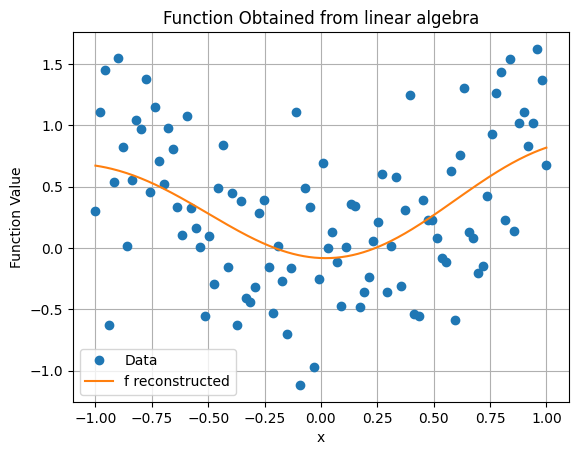

In [83]:
nt = 250
x_prime = np.linspace(-1, 1, nt)
alpha = alpha_star

f_values_alpha_star = np.zeros_like(x_prime)

# Compute the function values for each point in the grid
for i, xi in enumerate(x_prime):
    # Evaluate the function at the current grid point
    f_values_alpha_star[i] = sum([alpha[j] * kernel(xi, x_selected[j]) for j in range(m)])

# Plot the obtained function
plt.plot(x[:n],y[:n], 'o', label = 'Data')
#plt.plot(x_selected, y_selected, 'o', label = 'Selected points')
plt.plot(x_prime, f_values_alpha_star, label='f reconstructed')
plt.xlabel('x')
plt.ylabel('Function Value')
plt.title('Function Obtained from linear algebra')
plt.legend()
plt.grid(True)
plt.show()

<h2> Decentralized gradient descent (DGD)

In this part we will need the value of $\alpha^{*}$ found above to compute the optimality gap at each iteration

For each agent $a \in \{1,...5\}$ we define the following function:

\begin{equation*} g_{a}(\alpha) = \frac{\sigma^2}{5}\frac{1}{2}\alpha^{T}K_{mm}\alpha + \frac{1}{2}\vert\vert y - K_{(i)m}\alpha\vert\vert + \frac{nu}{10}\vert\vert \alpha \vert \vert^{2}_{2} \end{equation*}

In [84]:
K = matrix_K(x[:n], x[:n])
Kmm = K[ind,:][:,ind]
agents = np.array_split(np.random.choice(np.array(range(n)),size=n, replace=False),a)

Chose learning rate :

In [85]:
m_a = np.zeros(a)
L_a = np.zeros(a)

for j in range(a):
    nabla_g = Kmm/5
    for i in agents[j]:
        Kim = K[i,:][ind]
        nabla_g += Kim@Kim.T/(sigma**2)
    eigenval, _ = np.linalg.eig(nabla_g)
    L_a[j] = np.max(np.abs(eigenval))
    m_a[j] = np.min(np.abs(eigenval))
L = np.max(L_a)
#m = np.min(m_a)


In [86]:
print("L = ", L)
#print("m = ", m)

L =  3825.382852315777


In [87]:
def compute_local_gradient(alpha, a, sigma, y, K, M, agents):
    
    Kmm = K[M,:][:,M]
    
    somme = np.zeros(len(alpha))
    for i in agents[a]:
        Kim = K[i,:][M]
        somme += (y[i] - Kim@alpha)*Kim.T
        
    return (sigma**2)*Kmm@alpha/5  - somme + (nu/len(agents))*alpha

In [88]:
def DGD(num_iterations, agents, ind, K, y, learning_rate, sigma, alpha_star):

    nb_agents = a
    
    m = len(ind)
    
    opt_gap = np.zeros((num_iterations,nb_agents)) # optimality gap
    
    #alpha = np.random.normal(size=(nb_agents, m)) # randomly initialize the value of alpha
    alpha = np.zeros((nb_agents, m))
    
    for k in range(num_iterations):
        new_alpha = alpha.copy()
        
        # communicate the values of alpha between all the agents
        communicated = w@alpha
        
        for agent_id in range(nb_agents):
            grad = compute_local_gradient(alpha[agent_id], agent_id, sigma, y, K, ind, agents)
            new_alpha[agent_id] = communicated[agent_id] - learning_rate*grad
    
        alpha = new_alpha.copy()
        opt_gap[k] = np.linalg.norm(alpha - alpha_star,axis=1)

        
    return alpha, opt_gap

In [97]:
M = ind
W = w
true_alpha_linalg = alpha_star
num_iterations = 10000
K = matrix_K(x[:n],x[:n])
step_size = 0.001
alpha_dgd, opt_gap_dgd = DGD(num_iterations,agents,M, K,y[:n],step_size,sigma,true_alpha_linalg)

In [98]:
alpha_dgd = np.mean(alpha_dgd,axis=0)

In [99]:
alpha_dgd

array([ 0.10447515, -0.49197429, -0.62912349,  0.47048184, -0.01186899,
        0.4028138 , -0.30422618,  0.83203655,  0.257706  ,  0.5336415 ])

## Visualize the functions obtained

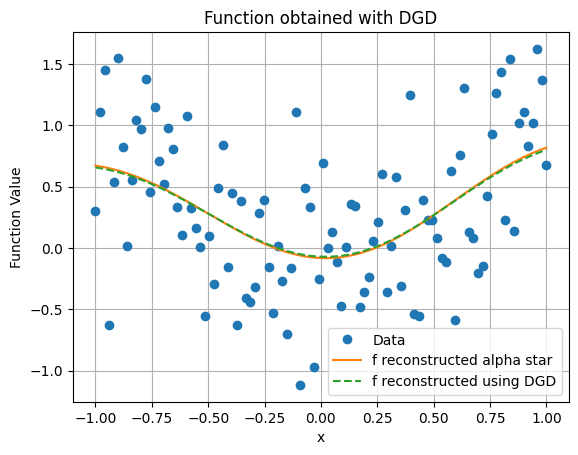

In [96]:
nt = 250
title = 'Function obtained with DGD'
method = 'DGD'
plot_f(nt, alpha_dgd, title, method)
x_prime = np.linspace(-1, 1, nt)

<h2> Plot optimality gap

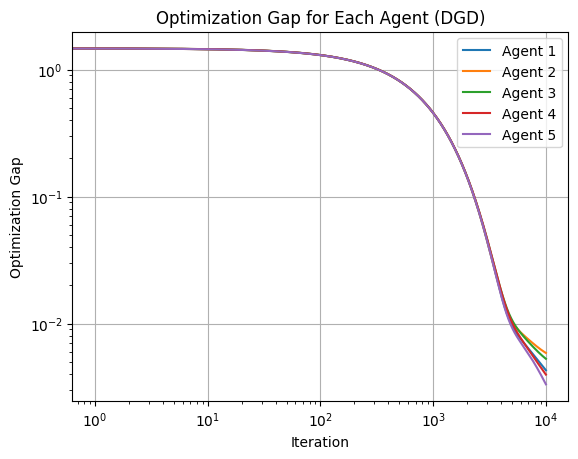

In [100]:
plt.figure()

for agent_idx in range(a):
    plt.loglog(range(num_iterations), opt_gap_dgd[:, agent_idx], label=f"Agent {agent_idx+1}")

plt.xlabel("Iteration")
plt.ylabel("Optimization Gap")
plt.title("Optimization Gap for Each Agent (DGD)")
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()

# Gradient tracking

In [101]:
def gradient_tracking(num_iterations, agents, ind, K, y, learning_rate, sigma, alpha_star):
    
    nb_agents = len(agents) # Number of agents at play
    m = len(ind)
    opt_gap = np.zeros((num_iterations, nb_agents))

    alpha = np.random.normal(size=(nb_agents, m)) # randomly initialize the value of alpha
    
    g_k = alpha.copy()
    for a in range(nb_agents):
        g_k[a] = compute_local_gradient(alpha[a], a, sigma, y, K, ind, agents)
    
    for k in range(num_iterations):

        new_alpha = alpha.copy()
        new_alpha = w@alpha - learning_rate*g_k

        # We update g
        #new_g = g_k.copy()
        # Mixing
        new_g = W@g_k
        #Update
        for a in range(nb_agents):
            grad_k_plus_1 = compute_local_gradient(new_alpha[a],a,sigma,y,K,ind,agents)
            grad_k = compute_local_gradient(alpha[a],a,sigma,y,K,ind,agents)
            new_g[a] += grad_k_plus_1 - grad_k
        
        alpha = new_alpha.copy()
        g_k = new_g.copy()
        opt_gap[k] = np.linalg.norm(alpha - alpha_star,axis=1)
        
    return alpha, opt_gap

In [102]:
def g(alpha,K,M,Y,n,sigma):
    K_mm = K[M,:][:,M]
    K_nm = K[:n][:,M]
    return alpha.T@K_mm@alpha/2 +  np.linalg.norm(Y[:n] - K_nm@alpha,ord=2)**2/(2*sigma**2)

In [103]:
def g(alpha,K,M,Y,n,sigma):
    K_mm = K[M,:][:,M]
    K_nm = K[:n][:,M]
    return alpha.T@K_mm@alpha/2 +  np.linalg.norm(Y[:n] - K_nm@alpha,ord=2)**2/(2*sigma**2)

In [106]:
true_alpha_linalg = alpha_star
num_iterations = 10000
learning_rate = 0.001
K = matrix_K(x[:n],x[:n])
alpha_gt, opt_gap_gt = gradient_tracking(num_iterations, agents, ind, K, y, learning_rate, sigma, alpha_star)

In [107]:
alpha_gt = np.mean(alpha_gt,axis=0)

In [108]:
alpha_gt

array([ 0.17682123, -0.46163412, -0.73123932,  0.41965892,  0.04279029,
        0.32178309, -0.27474559,  0.79786757,  0.27588321,  0.58900293])

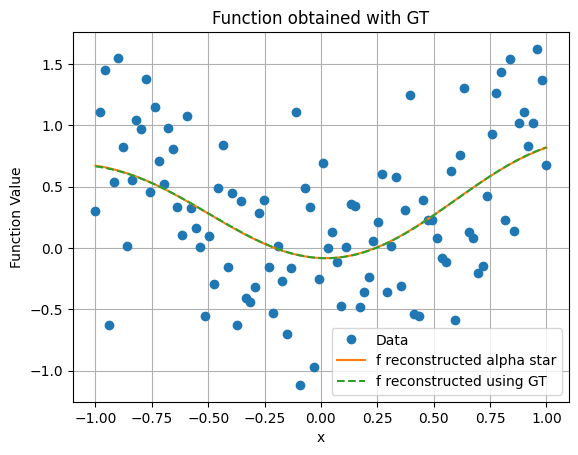

In [109]:
nt = 250
title = 'Function obtained with GT'
method = 'GT'
plot_f(nt, alpha_gt, title, method)

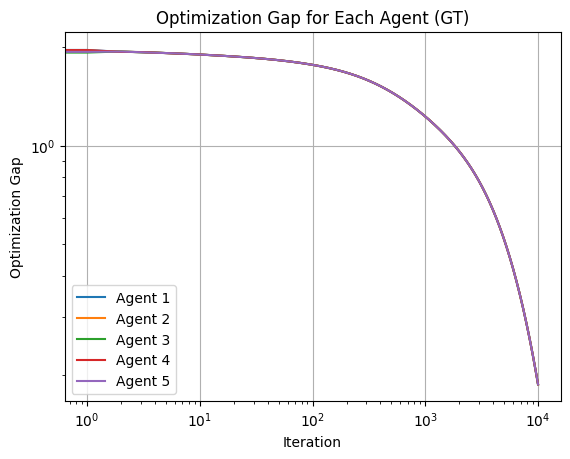

In [110]:

plt.figure()

for agent_idx in range(a):
    plt.loglog(range(num_iterations), opt_gap_gt[:, agent_idx], label=f"Agent {agent_idx+1}")

plt.xlabel("Iteration")
plt.ylabel("Optimization Gap")
plt.title("Optimization Gap for Each Agent (GT)")
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()

<h2> Dual Decomposition

In [212]:
def dual_decomposition(num_iterations, agents, ind, K, y, step_size, sigma, regularization):
    nb_agents = len(agents)
    m = len(ind)

    # Initialize dual variables and local optimization variables
    dual_variables = np.random.normal(size=(nb_agents, nb_agents, m))
    alpha = np.random.normal(size=(nb_agents, m))

    # Initialize optimality gap
    opt_gap = np.zeros((num_iterations, nb_agents))

    for k in range(num_iterations):

        for a in range(nb_agents):
            # Compute matrices A and vectors b for solving the local optimization problem
            Kmm = K[ind,:][:,ind]
            somme = np.zeros(Kmm.shape)
            
            for i in agents[a]:
                Kim = K[i,:][ind]
                somme += Kim.reshape(m, 1) @ Kim.reshape(1, m)
            
            A = Kmm / 5 + somme / (sigma ** 2) + 2 * regularization * np.eye(m)
            
            # Compute vector b_1
            b_1 = np.zeros_like(alpha[a])
            for i in agents[a]:
                Kim = K[i,:][M]
                b_1 += y[i] * Kim.T
                
            # Compute vector b_2 by sending x_i*(lambda_k) to the neighbors
            b_2 = np.zeros_like(alpha[a])
            for b in range(nb_agents):
                if (W[a][b] != 0) and (b < a):
                    b_2 += dual_variables[a, b]
                elif (W[a][b] != 0) and (a < b):
                    b_2 -= dual_variables[b, a]
            
            # Solve the linear system to update alpha
            alpha[a] = np.linalg.solve(A, b_1 / (sigma ** 2) - b_2)

        # Update dual variables lambda
        for i in range(nb_agents):
            for j in range(0, i):
                dual_variables[i, j] += step_size * (alpha[i] - alpha[j])

        # Compute optimality gap for each agent
        for a in range(nb_agents):
            opt_gap[k, a] = np.linalg.norm((alpha[a] - alpha_star))

    return alpha, opt_gap, dual_variables

In [222]:
true_alpha_linalg = alpha_star
regularization = 0.005
num_iterations = 1000
learning_rate = 0.001
K = matrix_K(x[:n],x[:n])

alpha_dd, opt_gap_dd, z = dual_decomposition(num_iterations, agents, ind, K, y[:n], step_size, sigma, regularization)
#alpha_dd, opt_gap_dd = dual_decomposition(num_iterations, agents, ind, w, K, y[:n], learning_rate, sigma, regularization)

In [223]:
alpha_dd = np.mean(alpha_dd, axis = 0)

In [224]:
alpha_dd

array([-0.12646741, -0.42076923, -0.34146718,  0.96978908, -0.35893519,
        0.72406219, -0.68864387,  1.47180018,  0.26419223, -0.13602375])

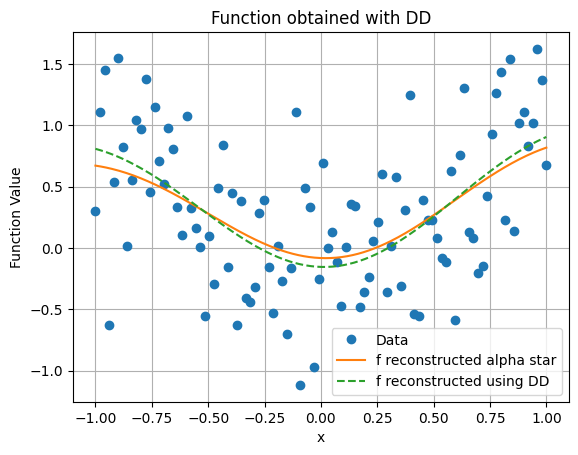

In [225]:
nt = 250
title = 'Function obtained with DD'
method = 'DD'
plot_f(nt, alpha_dd, title, method)

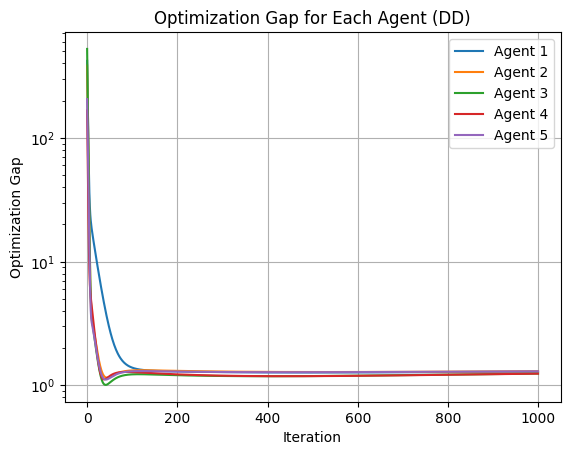

In [226]:
plt.figure()

for agent_idx in range(a):
    plt.plot(range(num_iterations), opt_gap_dd[:, agent_idx], label=f"Agent {agent_idx+1}")

plt.xlabel("Iteration")
plt.ylabel("Optimization Gap")
plt.title("Optimization Gap for Each Agent (DD)")
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()

<h2> Alternating Direction Method of Multipliers(ADMM)

In [205]:
def ADMM(num_iterations, agents, ind, K, y, sigma, beta):
    nb_agents = len(agents)
    m = len(ind)

    # Initialize variables
    alpha = np.zeros((nb_agents, m))  # Local optimization variables
    opt_gap = np.zeros((num_iterations, m))
    dual_vars = np.zeros((nb_agents, m))  # Dual variables

    # Main loop for ADMM iterations
    for k in range(num_iterations):
        # Update alpha for each agent
        for a in range(nb_agents):
            # Compute matrices A_1 and A_2 for solving the local optimization problem
            Kmm = K[ind, :][:, ind]  # Subset of kernel matrix corresponding to local data

            sum_matrix = np.zeros_like(Kmm)
            for i in agents[a]:
                Ki_m = K[i, :][ind]
                sum_matrix += Ki_m.reshape(m, 1) @ Ki_m.reshape(1, m)

            A = Kmm / 5 + sum_matrix / (sigma ** 2) + beta * np.eye(m)

            # Compute vector b for solving the linear system
            b = np.zeros_like(alpha[a])
            for i in agents[a]:
                Ki_m = K[i, :][ind]
                b += y[i] * Ki_m.T

            # Solve the linear system to update alpha
            alpha[a] = np.linalg.solve(A, b / (sigma ** 2) + beta * np.sum(dual_vars, axis=0) / nb_agents)

        # Update dual variables
        for i in range(nb_agents):
            dual_vars[i] = np.mean(alpha, axis=0)

        # Compute optimality gap
        opt_gap[k] = np.linalg.norm(alpha - alpha_star)

    return alpha, opt_gap

In [206]:
num_iterations = 1000
beta = 100
regularization = 0.005
rho = 1
K = matrix_K(x[:n],x[:n])
alpha_admm, opt_gap_admm = ADMM(num_iterations, agents, ind, K, y, sigma, beta)

In [207]:
alpha_admm

array([[ 0.06444299, -0.57330872, -0.73534667,  0.64275542, -0.09927345,
         0.52800266, -0.46849667,  1.0358247 ,  0.29438813,  0.56121646],
       [ 0.08828383, -0.54389435, -0.70688974,  0.66588462, -0.0752417 ,
         0.55130629, -0.4437893 ,  1.05302311,  0.31798006,  0.58412109],
       [ 0.06981448, -0.58012003, -0.72968975,  0.63281803, -0.09003411,
         0.52127453, -0.45197947,  0.98929463,  0.29394057,  0.51711003],
       [ 0.08725384, -0.53863491, -0.6907248 ,  0.64982652, -0.07169805,
         0.53808087, -0.42955321,  1.00442117,  0.31075514,  0.5424228 ],
       [ 0.07797858, -0.57290876, -0.73045158,  0.65286081, -0.08521083,
         0.53896561, -0.45438848,  1.02642984,  0.30682987,  0.55219599]])

In [208]:
alpha_admm = np.mean(alpha_admm,axis=0)


In [209]:
alpha_admm

array([ 0.07755474, -0.56177336, -0.71862051,  0.64882908, -0.08429163,
        0.53552599, -0.44964143,  1.02179869,  0.30477875,  0.55141327])

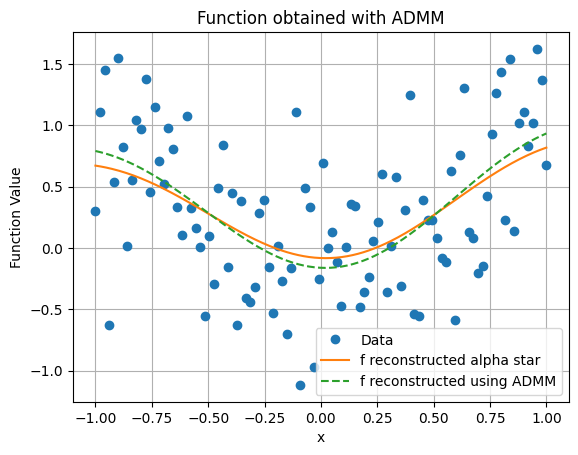

In [210]:
nt = 250
title = 'Function obtained with ADMM'
method = 'ADMM'
plot_f(nt, alpha_admm, title, method)

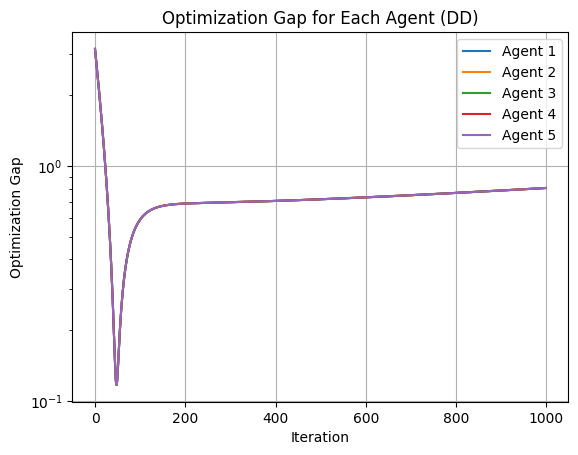

In [211]:
plt.figure()

for agent_idx in range(a):
    plt.plot(range(num_iterations), opt_gap_admm[:, agent_idx], label=f"Agent {agent_idx+1}")

plt.xlabel("Iteration")
plt.ylabel("Optimization Gap")
plt.title("Optimization Gap for Each Agent (DD)")
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()